In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = MNIST(root='data/', train=True, transform=ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 82418066.53it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72061685.80it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19283067.37it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12426959.41it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(dataset)

60000

In [ ]:
train_lenght = 50000
valid_length = len(dataset) - train_lenght
train_ds, valid_ds = random_split(dataset, [train_lenght, valid_length])

In [ ]:
len(train_ds), len(valid_ds)

(50000, 10000)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size * 2, num_workers=4, pin_memory=True)
len(train_loader), len(valid_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(391, 40)

In [ ]:
for batch in train_loader:
    images, labels = batch
    print(images.shape)
    inputs = images.reshape(-1, 784)
    print(inputs.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [ ]:
input_size = 784
input_size

784

In [ ]:
hidden_size = 32
output_size = 10

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
layer1_output = layer1(inputs)

In [ ]:
layer1_output.shape

torch.Size([128, 32])

In [ ]:
layer1_output

tensor([[-0.3601, -0.0895, -0.1556,  ..., -0.0896,  0.0103,  0.0498],
        [-0.5121, -0.0839, -0.0836,  ..., -0.1305,  0.2450, -0.1066],
        [-0.1163,  0.0382, -0.0425,  ..., -0.1344,  0.0579, -0.3537],
        ...,
        [-0.1191, -0.2313, -0.0477,  ..., -0.5457,  0.2694, -0.1134],
        [ 0.1187, -0.1402,  0.0905,  ..., -0.1163,  0.1721, -0.1669],
        [ 0.0254, -0.0229, -0.1455,  ..., -0.1174,  0.0344, -0.2503]],
       grad_fn=<AddmmBackward0>)

In [ ]:
layer1_output_direct = inputs @ layer1.weight.t() + layer1.bias
torch.allclose(layer1_output, layer1_output_direct, 1e-3)

True

In [ ]:
layer1_output_relu = F.relu(layer1_output)

In [ ]:
print(torch.min(layer1_output).item())
print(torch.min(layer1_output_relu).item())

-0.7650220990180969
0.0


In [ ]:
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_output = layer2(layer1_output_relu)
layer2_output.shape

torch.Size([128, 10])

In [ ]:
layer2_output

tensor([[ 0.1809,  0.0236, -0.2181,  ...,  0.1270, -0.2281,  0.1586],
        [ 0.2524,  0.0076, -0.1175,  ...,  0.1046, -0.1668,  0.1403],
        [ 0.1877,  0.0157, -0.1779,  ...,  0.1682, -0.0914,  0.1481],
        ...,
        [ 0.2409,  0.0223, -0.1782,  ...,  0.1859, -0.1148,  0.1311],
        [ 0.1923, -0.0427, -0.1366,  ...,  0.0835, -0.1348,  0.1713],
        [ 0.2031, -0.0363, -0.1674,  ...,  0.1676, -0.1423,  0.1480]],
       grad_fn=<AddmmBackward0>)

In [ ]:
layer2_output_direct = F.relu(inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [ ]:
torch.allclose(layer2_output, layer2_output_direct, 1e-3)

True

In [ ]:
combined_layer = nn.Linear(inputs.shape[1], output_size)
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [ ]:
output_combined = combined_layer(inputs)
output_normal = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias
torch.allclose(output_combined, output_normal, 1e-3)

True

In [ ]:
class MnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # first layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        # second layer
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, xb): #suggestion build CNN, feed forward
        xb = xb. reshape(-1, 784)
        # output of the first layer
        out = self.layer1(xb)
        # output of relu function
        out = F.relu(out)
        # final output
        out = self.layer2(out)
        return out
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
model = MnistModel(784, 32, 10)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, valid_loader):
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, valid_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # training phrase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # validation phrase
        result = evaluate(model, valid_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_loader)]
history

[{'val_loss': 2.311767339706421, 'val_acc': 0.09707031399011612}]

In [ ]:
history += fit(5, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.3060, val_acc: 0.0988
Epoch [1], val_loss: 2.3003, val_acc: 0.1013
Epoch [2], val_loss: 2.2946, val_acc: 0.1046
Epoch [3], val_loss: 2.2888, val_acc: 0.1075
Epoch [4], val_loss: 2.2828, val_acc: 0.1112


In [ ]:
history += fit(5, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.2767, val_acc: 0.1156
Epoch [1], val_loss: 2.2706, val_acc: 0.1196
Epoch [2], val_loss: 2.2642, val_acc: 0.1260
Epoch [3], val_loss: 2.2578, val_acc: 0.1340
Epoch [4], val_loss: 2.2513, val_acc: 0.1445


In [ ]:
history += fit(5, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.2447, val_acc: 0.1552
Epoch [1], val_loss: 2.2380, val_acc: 0.1696
Epoch [2], val_loss: 2.2312, val_acc: 0.1824
Epoch [3], val_loss: 2.2244, val_acc: 0.2025
Epoch [4], val_loss: 2.2174, val_acc: 0.2172


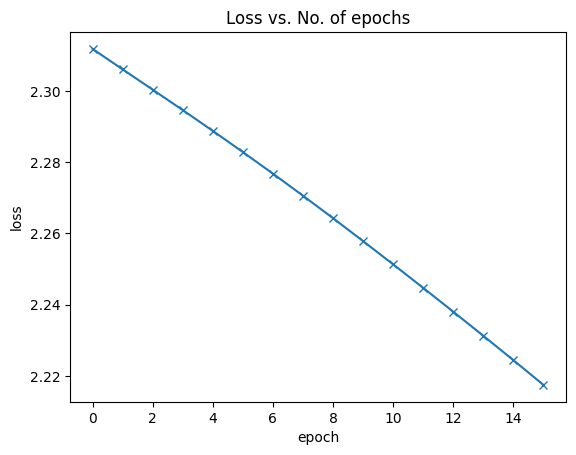

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

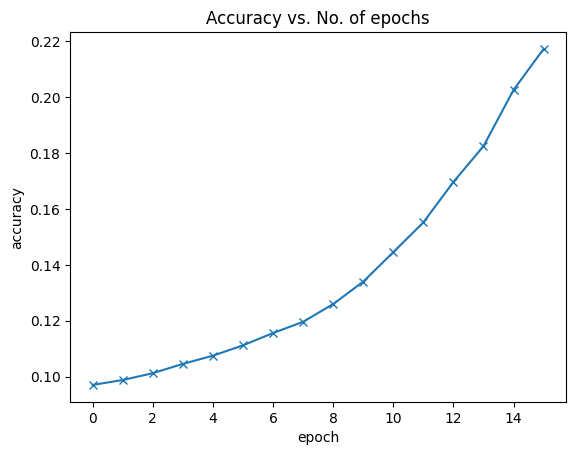

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
history += fit(5, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.2104, val_acc: 0.2338
Epoch [1], val_loss: 2.2032, val_acc: 0.2491
Epoch [2], val_loss: 2.1960, val_acc: 0.2658
Epoch [3], val_loss: 2.1886, val_acc: 0.2777
Epoch [4], val_loss: 2.1810, val_acc: 0.2881


In [ ]:
history += fit(5, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.1734, val_acc: 0.3002
Epoch [1], val_loss: 2.1656, val_acc: 0.3098
Epoch [2], val_loss: 2.1577, val_acc: 0.3192
Epoch [3], val_loss: 2.1497, val_acc: 0.3302
Epoch [4], val_loss: 2.1417, val_acc: 0.3410


In [ ]:
history += fit(5, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.1335, val_acc: 0.3479
Epoch [1], val_loss: 2.1252, val_acc: 0.3588
Epoch [2], val_loss: 2.1168, val_acc: 0.3673
Epoch [3], val_loss: 2.1083, val_acc: 0.3764
Epoch [4], val_loss: 2.0997, val_acc: 0.3881


In [ ]:
history += fit(50, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 2.0910, val_acc: 0.4044
Epoch [1], val_loss: 2.0822, val_acc: 0.4215
Epoch [2], val_loss: 2.0733, val_acc: 0.4357
Epoch [3], val_loss: 2.0642, val_acc: 0.4505
Epoch [4], val_loss: 2.0550, val_acc: 0.4656
Epoch [5], val_loss: 2.0457, val_acc: 0.4798
Epoch [6], val_loss: 2.0363, val_acc: 0.4913
Epoch [7], val_loss: 2.0267, val_acc: 0.5027
Epoch [8], val_loss: 2.0170, val_acc: 0.5121
Epoch [9], val_loss: 2.0072, val_acc: 0.5231
Epoch [10], val_loss: 1.9974, val_acc: 0.5313
Epoch [11], val_loss: 1.9873, val_acc: 0.5403
Epoch [12], val_loss: 1.9772, val_acc: 0.5471
Epoch [13], val_loss: 1.9670, val_acc: 0.5539
Epoch [14], val_loss: 1.9566, val_acc: 0.5598
Epoch [15], val_loss: 1.9462, val_acc: 0.5704
Epoch [16], val_loss: 1.9356, val_acc: 0.5755
Epoch [17], val_loss: 1.9250, val_acc: 0.5821
Epoch [18], val_loss: 1.9142, val_acc: 0.5883
Epoch [19], val_loss: 1.9034, val_acc: 0.5929
Epoch [20], val_loss: 1.8924, val_acc: 0.5972
Epoch [21], val_loss: 1.8814, val_acc: 0.600

In [ ]:
history += fit(50, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 1.5416, val_acc: 0.6899
Epoch [1], val_loss: 1.5298, val_acc: 0.6919
Epoch [2], val_loss: 1.5180, val_acc: 0.6938
Epoch [3], val_loss: 1.5063, val_acc: 0.6951
Epoch [4], val_loss: 1.4947, val_acc: 0.6969
Epoch [5], val_loss: 1.4831, val_acc: 0.6987
Epoch [6], val_loss: 1.4715, val_acc: 0.7014
Epoch [7], val_loss: 1.4600, val_acc: 0.7037
Epoch [8], val_loss: 1.4486, val_acc: 0.7056
Epoch [9], val_loss: 1.4372, val_acc: 0.7077
Epoch [10], val_loss: 1.4259, val_acc: 0.7087
Epoch [11], val_loss: 1.4147, val_acc: 0.7104
Epoch [12], val_loss: 1.4035, val_acc: 0.7124
Epoch [13], val_loss: 1.3924, val_acc: 0.7139
Epoch [14], val_loss: 1.3814, val_acc: 0.7153
Epoch [15], val_loss: 1.3705, val_acc: 0.7168
Epoch [16], val_loss: 1.3597, val_acc: 0.7182
Epoch [17], val_loss: 1.3489, val_acc: 0.7188
Epoch [18], val_loss: 1.3383, val_acc: 0.7205
Epoch [19], val_loss: 1.3278, val_acc: 0.7223
Epoch [20], val_loss: 1.3173, val_acc: 0.7241
Epoch [21], val_loss: 1.3070, val_acc: 0.725

In [ ]:
history += fit(50, 0.0001, model, train_loader, valid_loader)

Epoch [0], val_loss: 1.0537, val_acc: 0.7688
Epoch [1], val_loss: 1.0465, val_acc: 0.7703
Epoch [2], val_loss: 1.0395, val_acc: 0.7719
Epoch [3], val_loss: 1.0326, val_acc: 0.7736
Epoch [4], val_loss: 1.0258, val_acc: 0.7753
Epoch [5], val_loss: 1.0190, val_acc: 0.7767
Epoch [6], val_loss: 1.0124, val_acc: 0.7792
Epoch [7], val_loss: 1.0059, val_acc: 0.7812
Epoch [8], val_loss: 0.9994, val_acc: 0.7829
Epoch [9], val_loss: 0.9931, val_acc: 0.7841
Epoch [10], val_loss: 0.9868, val_acc: 0.7863
Epoch [11], val_loss: 0.9806, val_acc: 0.7878
Epoch [12], val_loss: 0.9745, val_acc: 0.7884
Epoch [13], val_loss: 0.9685, val_acc: 0.7897
Epoch [14], val_loss: 0.9626, val_acc: 0.7910
Epoch [15], val_loss: 0.9568, val_acc: 0.7924
Epoch [16], val_loss: 0.9510, val_acc: 0.7938
Epoch [17], val_loss: 0.9454, val_acc: 0.7942
Epoch [18], val_loss: 0.9398, val_acc: 0.7947
Epoch [19], val_loss: 0.9343, val_acc: 0.7956
Epoch [20], val_loss: 0.9288, val_acc: 0.7967
Epoch [21], val_loss: 0.9235, val_acc: 0.797

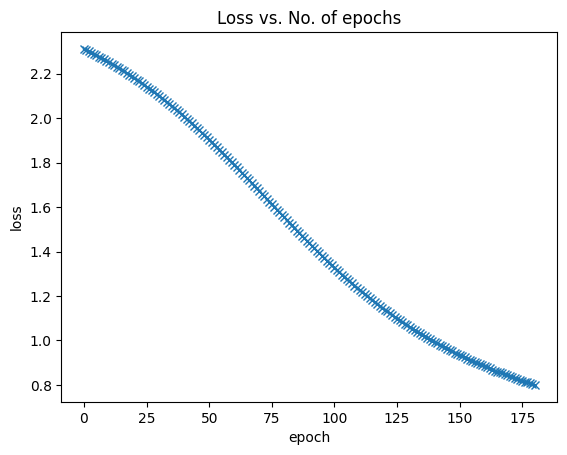

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

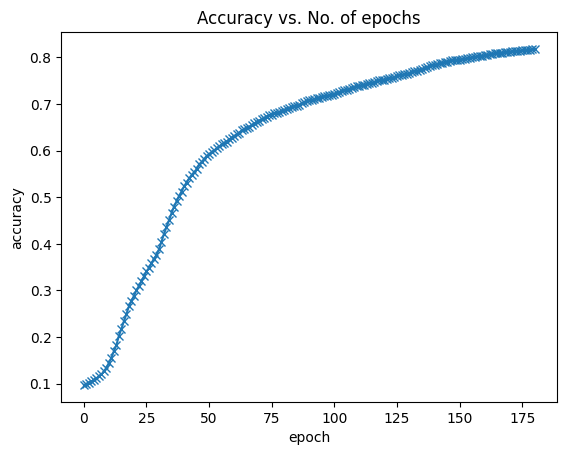

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');